In [51]:
import os, sys
import numpy as np
import keras.layers
from keras import backend as K
import tensorflow as tf
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [52]:
#Fusion Model
sys.path.append('/Users/user/Desktop/UPMC/EPFL/Research/repo/fusion/')

In [53]:
from filters import *
import vggfusiongpu as fu
from torchvision.models.vgg import vgg19

In [43]:
from skimage.transform import resize

In [54]:
model = vgg19(True).eval()

In [55]:
from skimage import io
from skimage import color
from imageio import imread, imwrite

In [56]:
def dataload(path1,  size = (240, 320)):
    """
    inputs: rgb_dataset, ir_dataset : path to rgb, ir dataset respectively
    returns: ir, visible arrays contains ndarrays for imgs 
    """
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]
    #onlyfiles1 = onlyfiles1[1:]
    onlyfiles1.sort()

    visible = np.ndarray(shape=(len(onlyfiles1), size[0], size[1]), dtype = np.float32)
    i = 0
    for img_name in tqdm(onlyfiles1):
        img_path = path1 + "/" + img_name
        img = load_img(img_path, color_mode = "grayscale")                            
        # Convert to Numpy Array
        x = img_to_array(img)  
        x = resize(x, size)                         #Output: (256, 256, 1)
        #print(x.shape)
        x = x.reshape(size)
        visible[i] = x
        i += 1
    print("\t############# All VISIBLE images to array ##########")
    return visible

In [57]:
def segmentation_ir(img):
    """
    img: path to IR image
    """
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    histogram = cv2.calcHist([blurred], [0], None, [256], [0, 256])
    hist_normalize = histogram.ravel() / histogram.max()
    Q = hist_normalize.cumsum()
    x_axis = np.arange(256)
    mini = np.inf
    epsilon = 10^(-8)
    for i in range(1, 256):
        p1, p2 = np.hsplit(hist_normalize, [i])
        q1, q2 = Q[i], Q[255] - Q[i]
        b1, b2 = np.hsplit(x_axis, [i])
        m1, m2 = np.sum(p1 * b1) / (q1+epsilon), np.sum(p2 * b2) / (q2+epsilon)
        v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / (q1+epsilon), np.sum(((b2 - m2) ** 2) * p2) / (epsilon+q2)
        fn = v1 * q1 + v2 * q2
        if fn < mini:
            mini = fn
    #ret, binarized = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)
    ret, binarized = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # use the mask to select the "interesting" part of the image
    im_thresh = cv2.bitwise_and(img, binarized)
    return binarized, im_thresh

In [58]:
def segmentation_infrared(imgs):
	#Output array : is sample * H * W * 1
	output_array = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2]))
	output_array = output_array.astype(float)

	#for i in tqdm(range(imgs.shape[0])):
	for i in tqdm(range(imgs.shape[0])):
		binary, seg_img = segmentation_ir(imgs[i])
		output_array[i] = binary
	return output_array

----------------------------------------------------------------------------------------------------------------

In [59]:
print("\t################# Loading Datasets #################")
#Working on visible data  SAVE_1_ir0_AFI.zip
path_ir1 = "/Volumes/IEMPROG/dataset/SAVE_1_ir0_AFI"
path_vis1 = "/Volumes/IEMPROG/dataset/SAVE_1_visible_AFI"

#Working on visible data  SAVE_1_ir0_AFI.zip
path_ir2 = "/Volumes/IEMPROG/dataset/SAVE_2_ir0_AFI"
path_vis2 = "/Volumes/IEMPROG/dataset/SAVE_2_visible_AFI"

#Working on visible data  SAVE_2_ir0_HAK.zip
path_ir3 = "/Volumes/IEMPROG/dataset/SAVE_2_ir0_HAK"
path_vis3 = "/Volumes/IEMPROG/dataset/SAVE_2_visible_HAK"

#Working on visible data  SAVE_4_ir0_ARO.zip
path_ir4 = "/Volumes/IEMPROG/dataset/SAVE_4_ir0_ARO"
path_vis4 = "/Volumes/IEMPROG/dataset/SAVE_4_visible_ARO"

	################# Loading Datasets #################


In [60]:
vis = dataload(path_vis2)

100%|██████████| 2828/2828 [00:38<00:00, 73.65it/s] 

	############# All VISIBLE images to array ##########


In [61]:
#Saving
nom_video = "SAVE_2_visible_AFI"
path_registration = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Registred/" + nom_video

In [62]:
print(path_registration)
frames_to_fuse = dataload(path_registration)

 10%|█         | 5/50 [00:00<00:00, 49.39it/s]

/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Registred/SAVE_2_visible_AFI


100%|██████████| 50/50 [00:00<00:00, 75.18it/s]

	############# All VISIBLE images to array ##########


In [63]:
def fuse_twoscale(vis, ir, **kwargs):
    with_exp = kwargs.get('with_exp', True)
    kernel = kwargs.get('kernel', 45)
    r1 = kwargs.get('r1', 45)
    eps1 = kwargs.get('eps1', 0.01)
    r2 = kwargs.get('r2', 7)
    eps2 = kwargs.get('eps2', 10e-6)
    layer = kwargs.get('layer', 2)
    
    k = (kernel, kernel)
    
    # Decomposition
    V = vis / 255.
    Bv = cv2.blur(V, k) 
    Dv = V - Bv

    I = ir / 255.
    Bi = cv2.blur(I, k)
    Di = I - Bi
    
    # Base Fusion
    P1 = SalWeights([vis, ir])
    P1 = [P1[:,:,0], P1[:,:,1]]
    Wb = GuidedOptimize([V, I], P1, r1, eps1)
    fT2 = FuseWeights([Bv, Bi], Wb)

    # Detail Fusion
    DT = fu.fuse([Dv, Di], model, with_exp=with_exp, layer_number=layer)
    Wd = DT[0].cpu().numpy()
    fT1 = FuseWeights([Dv, Di], np.dstack(Wd))
    
    # Reconstruction
    fT = fT2 + fT1
    fT = np.clip(fT, 0, 1)
    fT = (fT*255).astype(np.uint8)
    
    return fT

In [66]:
print("\tFrames_to_fuse.shape: ", frames_to_fuse.shape)
print("\tVIS.shape: ", vis.shape)

	frames_to_fuse.shape:  (50, 240, 320)
	VIS.shape:  (2828, 240, 320)


In [67]:
vis_sub = vis[:50]
print("\tVIS.shape: ", vis_sub.shape)

	VIS.shape:  (50, 240, 320)


In [68]:
print("\tFrames_to_fuse.max: ", frames_to_fuse.max())
print("\tVIS.max: ", vis.max())

	Frames_to_fuse.max:  255.0
	VIS.max:  255.0


In [69]:
#Saving
nom_video = "SAVE_2_visible_AFI"
path_fusion = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Fusion/" + nom_video

In [ ]:
#################################################
##			  Fusion of IR & RGB 		       ##
#################################################
for i in tqdm(range(1, 15)):
    name = "frame"+str(i)+".jpg"
    img_reg = path_registration + "/" + name
    img_path_vis = path_vis2 + "/" + name
    
    #print(type(img_path_vis))
    print(img_reg)
    ir_sample = color.rgb2gray(imread(img_reg))
    vis_sample = color.rgb2gray(imread(img_path_vis))
    
    #ir_sample = ir_sample.astype(np.int64)
    #vis_sample = vis_sample.astype(np.int64)
    
    #print("VIS_sample", type(vis_sample))
    #print("IR_sample", type(ir_sample))
    
    print("VIS_sample.shape: ", vis_sample.shape)
    print("IR_sample.shape: ",ir_sample.shape)
    
    #try:
    ir_sample = resize(ir_sample, (256, 256))
    ir_sample = ir_sample * 256
    
    ir_sample = ir_sample.astype(np.int64)
    vis_sample = vis_sample.astype(np.int64)
    
    fT = fuse_twoscale(vis_sample, ir_sample)
    fusion_name = "frame{}.jpg".format(i)
    print("fusion name: ", )
    output = path_fusion + "/" + fusion_name
    io.imsave(output, fT)

----------------------------------------------------------------------------------------------------------------

In [12]:
from PIL import Image

In [73]:
nom_video = "SAVE_2_visible_AFI"
path_fusion = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Fusion/" + nom_video

In [74]:
path_vis2 = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Registred/VISIBLE"

In [ ]:
#Saving
nom_video = "Registration"
path_registration = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Registred/" + nom_video

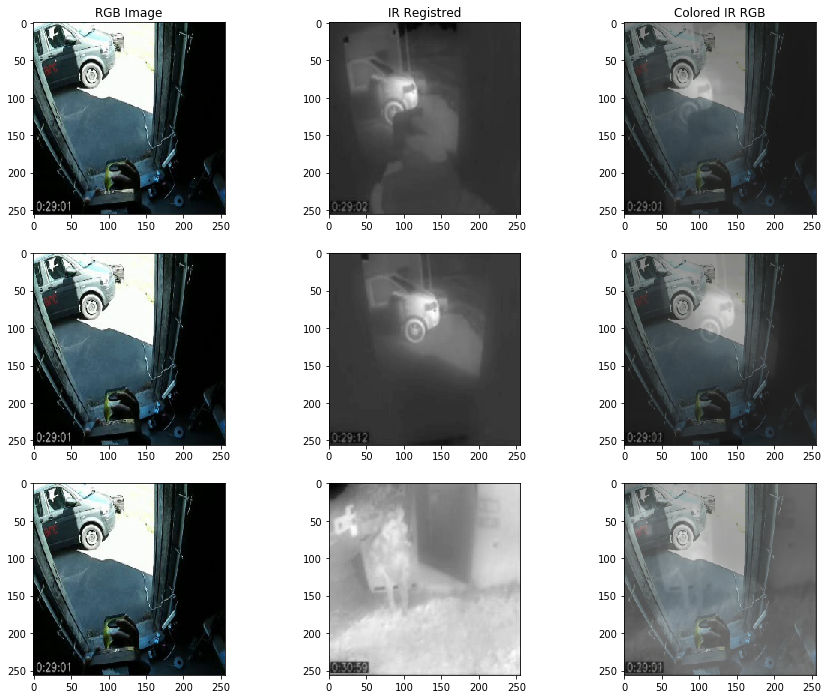

In [50]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
k = 0
for i in range(1, 4):
    name = "frame" + str(i) + ".jpg"
    path_v = path_vis2 + "/" + name
    path_fus = path_fusion + "/" + name
    
    img_vis = Image.open(path_v)
    img_fusion = Image.open(path_fus)
    
    img1 = img_vis.convert("RGBA")
    img2 = img_fusion.convert("RGBA")
    
    alphaBlended1 = Image.blend(img2, img1, alpha=.4)
    #alphaBlended2 = Image.blend(img_fusion, img2, alpha=.4)
    
    ax[k][0].imshow(img_vis, cmap='gray') #moving_images: IR
    ax[k][0].axis('on')
    ax[0][0].set_title("RGB Image")
    ax[k][1].imshow(img_fusion, cmap='gray') #moving_images: VIS
    ax[k][1].axis('on')
    ax[0][1].set_title("IR Registred")
    ax[k][2].imshow(alphaBlended1, cmap='gray') #moving_images: IR
    ax[k][2].axis('on')
    ax[0][2].set_title("Colored IR RGB")
    k += 1

--------------------------------------------------------------------------------------------------------------

In [41]:
video_name = "SAVE_2_visible_AFI_COLORED"
path_colored = "/Users/user/Desktop/UPMC/EPFL/Research/testing/dataset/Fusion/" + video_name

In [45]:
for i in tqdm(range(1, 51)):
    name = "frame" + str(i) + ".jpg"
    path_v = path_vis2 + "/" + name
    path_fus = path_fusion + "/" + name
    
    img_vis = Image.open(path_v)
    img_fusion = Image.open(path_fus)
    
    img1 = img_vis.convert("RGBA")
    img2 = img_fusion.convert("RGBA")
    
    alphaBlended1 = Image.blend(img2, img1, alpha=.2)
    #alphaBlended2 = Image.blend(img_fusion, img2, alpha=.4)
    
    #SAVING COLORED FRAMES
    output = path_colored + "/" + name
    
    #Convert to RGB format
    alphaBlended1 = alphaBlended1.convert("RGB")
    alphaBlended1.save(output)

100%|██████████| 50/50 [00:01<00:00, 45.77it/s]
